
### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
# Loading the dataset
df = pd.read_csv(r"data\raw\amz_uk_price_prediction_dataset.csv")

In [3]:
# Filtering out columns in the dataframe where more than 80% of the values are missing
df = df[df.columns[df.isnull().mean() < 0.8]]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 151.5+ MB


In [5]:
# Removing the "Id" column from the dataframe
df.drop("uid", inplace=True, axis=1)

In [6]:
df["stars"].nunique()

42

In [7]:
# Separating between discrete and continuous variables, as discrete ones could potentially be treated as categorical.
# Remember to adjust the threshold (in this case, < 20) based on your dataset's specific characteristics and domain knowledge.
potential_categorical_from_numerical = df[["stars"]]
potential_categorical_from_numerical

,stars
0,4.7
1,4.7
2,4.7
3,4.7
4,4.6
...,...
2443646,0.0
2443647,0.0
2443648,0.0
2443649,4.3


In [8]:
df_categorical = pd.concat([df.select_dtypes("object"), potential_categorical_from_numerical], axis=1)

# Adjusting the numerical dataframe by removing the moved columns
df_numerical = df.select_dtypes("number").drop(columns=potential_categorical_from_numerical.columns)

In [ ]:
#1.1
# Generating a crosstab for 'category' and 'isBestSeller'
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])


crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [10]:
# Calcular la proporción de Best Sellers por categoría
best_seller_proportion = (
    df.groupby('category')['isBestSeller']
    .mean()  # Proporción de Best Sellers en cada categoría
    .sort_values(ascending=False)  # Ordenar en orden descendente
)

# Mostrar las categorías ordenadas por proporción de Best Sellers
print(best_seller_proportion)

category
Grocery                             0.058135
Smart Home Security & Lighting      0.057692
Health & Personal Care              0.057686
Mobile Phone Accessories            0.042471
Power & Hand Tools                  0.035339
                                      ...   
CD, Disc & Tape Players             0.000000
General Music-Making Accessories    0.000000
Snowboard Boots                     0.000000
Boxes & Organisers                  0.000000
eBook Readers & Accessories         0.000000
Name: isBestSeller, Length: 296, dtype: float64


In [ ]:
#1.2

from scipy.stats import chi2_contingency

# Chi-square test for 'MSZoning' and 'SaleCondition'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

round(chi2_statistic,2), chi2_p_value

#P es menor a 0.05 por lo que se rechaza la hipotesis nula entonces hay una relaccion significativa

(36540.2, 0.0)

In [12]:
from scipy.stats.contingency import association

# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result, method="cramer")

#Unión leve

0.1222829439760564

In [31]:
#1.3

# Seleccionar las 15 categorías con más productos
top_categories = crosstab_result.sum(axis=1).nlargest(15).index

# Filtrar la tabla cruzada para incluir solo las principales categorías
filtered_crosstab = crosstab_result.loc[top_categories]


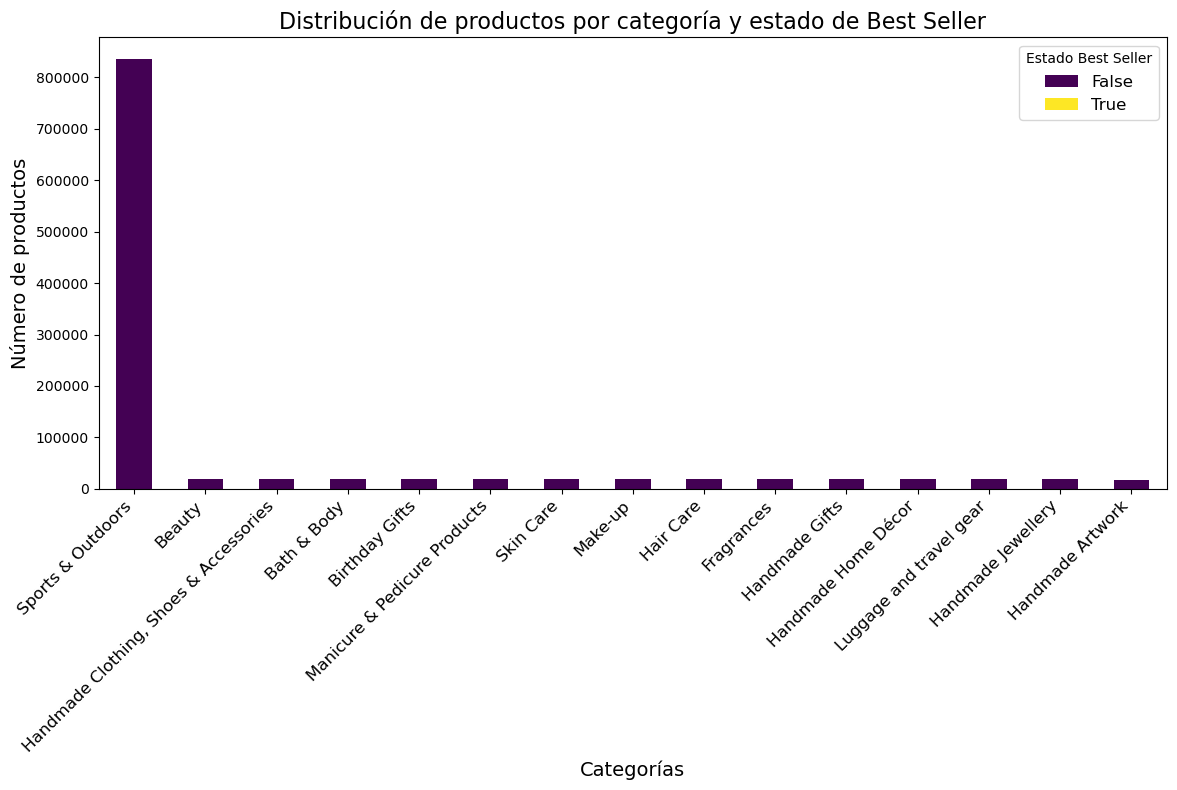

In [14]:
# Crear el gráfico de barras apiladas
filtered_crosstab.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')

# Mejorar las etiquetas y el diseño
plt.title('Distribución de productos por categoría y estado de Best Seller', fontsize=16)
plt.xlabel('Categorías', fontsize=14)
plt.ylabel('Número de productos', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.legend(title='Estado Best Seller', fontsize=12)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.


In [ ]:
#0
import pandas as pd


def tukeys_test_outliers(data):
    # Calcular los cuartiles y el rango intercuartil
    Q1 = data.quantile(0.25)  # Primer cuartil (25%)
    Q3 = data.quantile(0.75)  # Tercer cuartil (75%)
    IQR = Q3 - Q1             # Rango intercuartil

    # Definir los límites para identificar los outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identificar los valores atípicos
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    return outliers

# Aplicar la función a la columna 'price'
outliers_in_price = tukeys_test_outliers(df['price'])

# Mostrar los valores atípicos encontrados
print("Outliers encontrados en la columna 'price':")
print(outliers_in_price)


Outliers encontrados en la columna 'price':
10         139.00
19         164.99
25         149.99
28         289.00
31         199.99
            ...  
2443619    166.99
2443627    152.58
2443638    108.77
2443641    166.99
2443643    158.99
Name: price, Length: 327688, dtype: float64


In [16]:
# Obtener el índice de los outliers en la columna 'price'
outlier_indices = outliers_in_price.index

# Eliminar las filas correspondientes a los outliers
df_cleaned = df.drop(index=outlier_indices)

print(f"Filas antes de eliminar outliers: {len(df)}")
print(f"Filas después de eliminar outliers: {len(df_cleaned)}")


Filas antes de eliminar outliers: 2443651
Filas después de eliminar outliers: 2115963


C:\Users\est_c\AppData\Local\Temp\ipykernel_33608\373246070.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_df, x='category', y='price', palette="viridis")


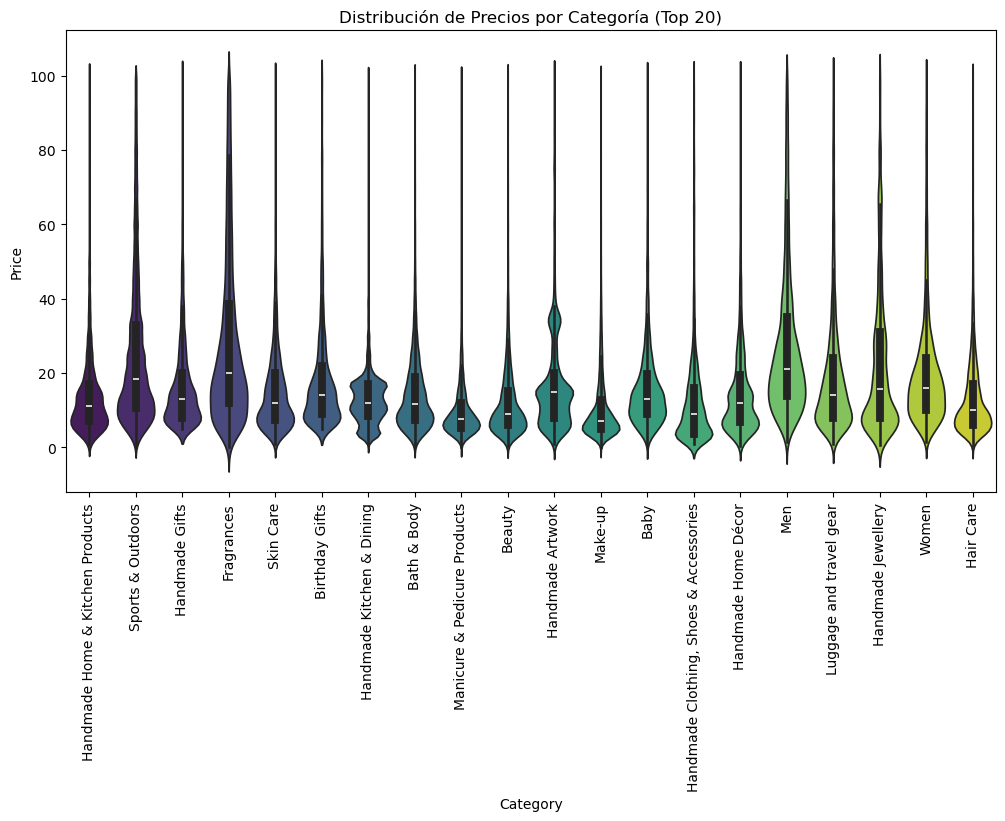

In [32]:
#2-1
import seaborn as sns
import matplotlib.pyplot as plt

# Identificar las 20 categorías principales basadas en el recuento
top20 = df_cleaned['category'].value_counts().head(20).index

# Filtrar el DataFrame para incluir solo las 20 categorías principales
filtered_df = df_cleaned[df_cleaned['category'].isin(top20)]

# Crear el violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=filtered_df, x='category', y='price', palette="viridis")
plt.xticks(rotation=90)
plt.title('Distribución de Precios por Categoría (Top 20)')
plt.ylabel('Price')
plt.xlabel('Category')
plt.show()


In [33]:
# Calcular la mediana del precio para cada categoría
median_price_by_category = df_cleaned.groupby('category')['price'].median()

# Identificar la categoría con la mediana más alta
highest_median_category = median_price_by_category.idxmax()
highest_median_price = median_price_by_category.max()

print(f"La categoría con la mediana de precio más alta es '{highest_median_category}' con una mediana de {highest_median_price:.2f}.")


La categoría con la mediana de precio más alta es 'Desktop PCs' con una mediana de 74.00.


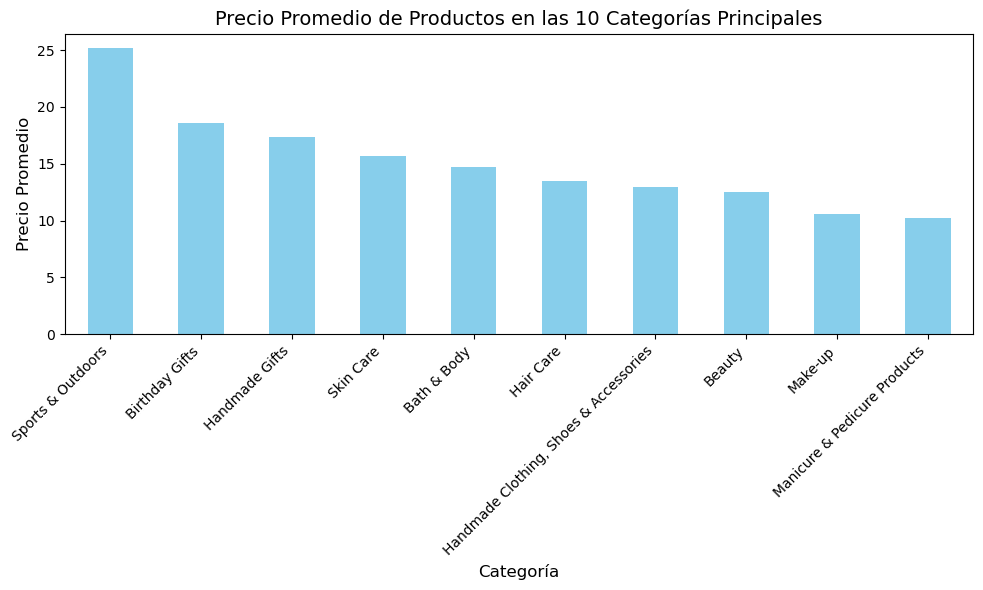

In [34]:
#2-2
import matplotlib.pyplot as plt

# Calcular el número de productos por categoría
category_counts = df_cleaned['category'].value_counts()

# Seleccionar las 10 categorías principales
top_10_categories = category_counts.head(10).index

# Filtrar el DataFrame para estas categorías
filtered = df_cleaned[df_cleaned['category'].isin(top_10_categories)]

# Calcular el precio promedio por categoría
avg_price_by_category = filtered.groupby('category')['price'].mean().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
avg_price_by_category.plot(kind='bar', color='skyblue')
plt.title('Precio Promedio de Productos en las 10 Categorías Principales', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Precio Promedio', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [35]:
# Calcular el precio promedio para todas las categorías
avg_price_all_categories = df_cleaned.groupby('category')['price'].mean()

# Identificar la categoría con el precio promedio más alto
highest_avg_price_category = avg_price_all_categories.idxmax()
highest_avg_price = avg_price_all_categories.max()

print(f"La categoría con el precio promedio más alto es '{highest_avg_price_category}' con un promedio de {highest_avg_price:.2f}.")


La categoría con el precio promedio más alto es 'Motherboards' con un promedio de 68.77.


C:\Users\est_c\AppData\Local\Temp\ipykernel_33608\3236520819.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered, x='category', y='stars', palette="Set3")


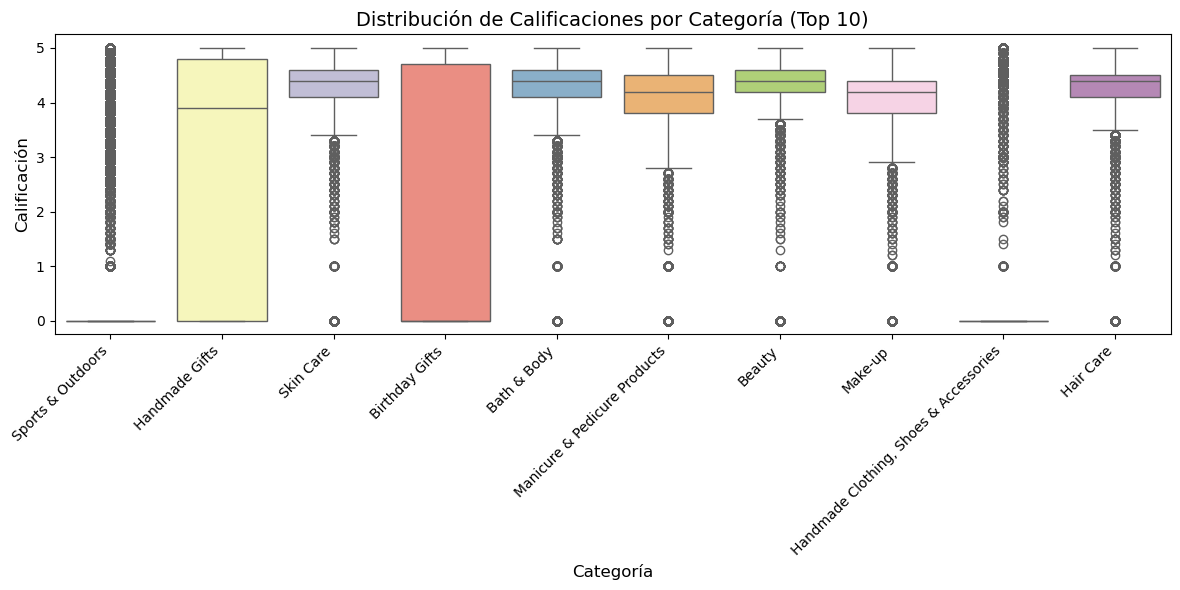

In [36]:
#2-3

import seaborn as sns
import matplotlib.pyplot as plt



# Crear el boxplot para las calificaciones por categoría
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered, x='category', y='stars', palette="Set3")
plt.title('Distribución de Calificaciones por Categoría (Top 10)', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Calificación', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [37]:
# Calcular la calificación media para todas las categorías
avg_rating_all_categories = df_cleaned.groupby('category')['stars'].mean()

# Identificar la categoría con la calificación media más alta
highest_avg_rating_category = avg_rating_all_categories.idxmax()
highest_avg_rating = avg_rating_all_categories.max()

print(f"La categoría con la calificación media más alta es '{highest_avg_rating_category}' con una calificación de {highest_avg_rating:.2f}.")


La categoría con la calificación media más alta es 'Luxury Food & Drink' con una calificación de 4.54.


### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?
	
2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

---

**Submission**: Submit a Jupyter Notebook which contains code and a business-centric report summarizing your findings. 

**Bonus**: 

- Do the same analysis without taking out the outliers. What are your insights?

In [23]:
#3-1
# Calcular el coeficiente de correlación entre 'price' y 'stars'
correlation = df[['price', 'stars']].corr().loc['price', 'stars']

print(f"Coeficiente de correlación entre 'price' y 'stars': {correlation:.4f}")


Coeficiente de correlación entre 'price' y 'stars': -0.1249


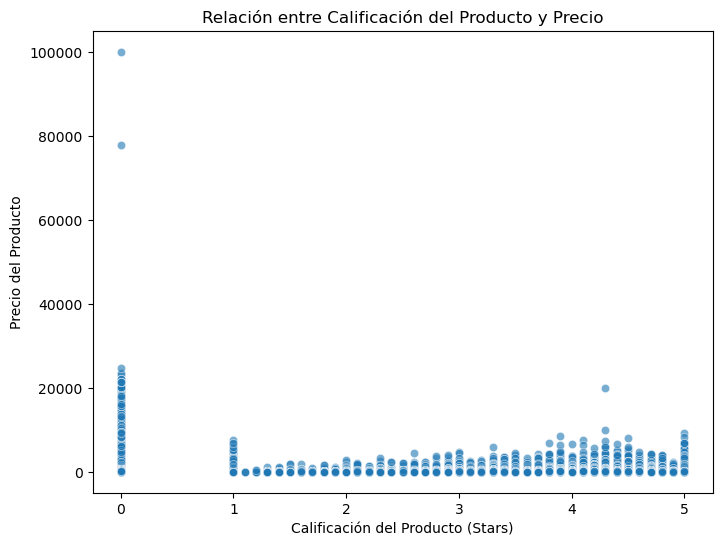

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el gráfico de dispersión
plt.figure(figsize=(8,6))
sns.scatterplot(x='stars', y='price', data=df, alpha=0.6)

# Añadir título y etiquetas
plt.title('Relación entre Calificación del Producto y Precio')
plt.xlabel('Calificación del Producto (Stars)')
plt.ylabel('Precio del Producto')

# Mostrar el gráfico
plt.show()

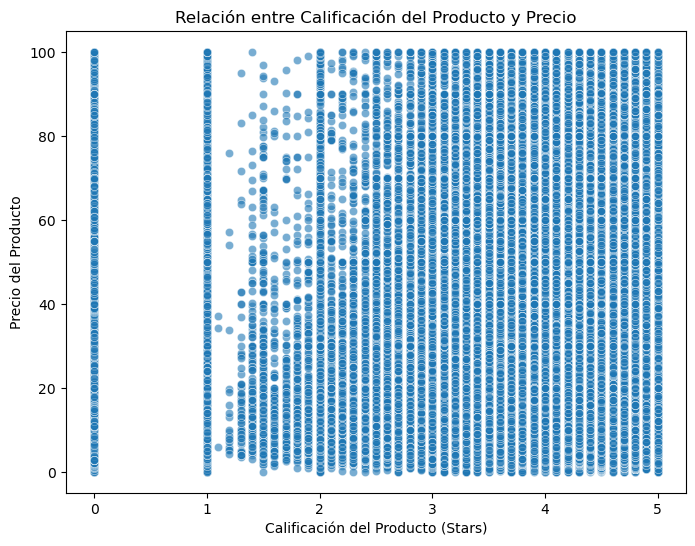

In [39]:
#3-2
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el gráfico de dispersión
plt.figure(figsize=(8,6))
sns.scatterplot(x='stars', y='price', data=df_cleaned, alpha=0.6)

# Añadir título y etiquetas
plt.title('Relación entre Calificación del Producto y Precio')
plt.xlabel('Calificación del Producto (Stars)')
plt.ylabel('Precio del Producto')

# Mostrar el gráfico
plt.show()

<Figure size 1000x800 with 0 Axes>

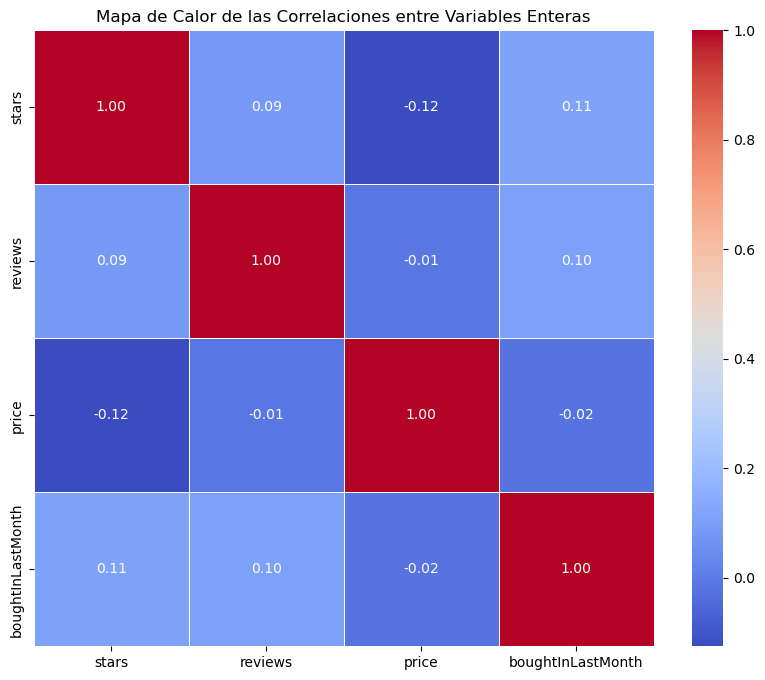

In [44]:
# Filtrar solo las columnas de tipo entero (int)
df_int = df.select_dtypes(include=["int64","float64"])

# Calcular la matriz de correlación solo para columnas enteras
corr_matrix = df_int.corr()

# Crear un heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Añadir título
plt.title('Mapa de Calor de las Correlaciones entre Variables Enteras')

# Mostrar el heatmap
plt.show()

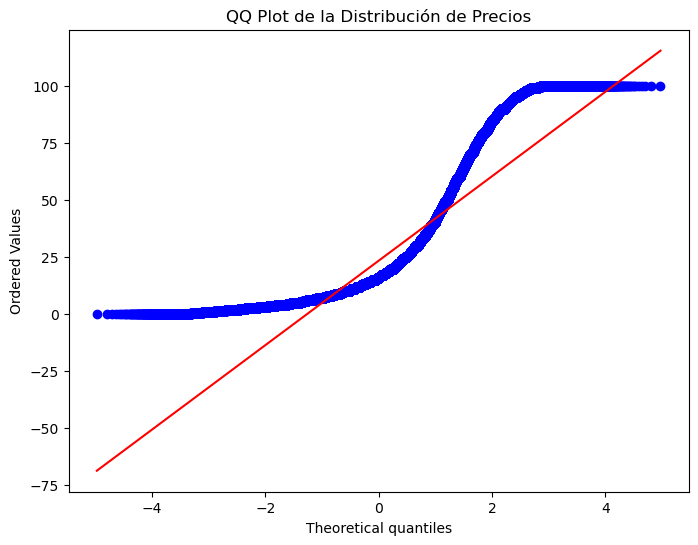

In [45]:
import scipy.stats as stats

# Crear el QQ plot para 'price'
plt.figure(figsize=(8,6))
stats.probplot(df_cleaned['price'], dist="norm", plot=plt)

# Título del gráfico
plt.title('QQ Plot de la Distribución de Precios')

# Mostrar el gráfico
plt.show()
